![alt](https://research.utm.my/wp-content/uploads/sites/26/2022/06/logo-300x122.png)
# Center for Artificial Intelligence and Robotics
#### Universiti Teknologi Malaysia


### Segmentation Inference - FCN ResNet-50

*Author: Pytorch Team*

**Fully-Convolutional Network model with ResNet-50 and ResNet-101 backbones**

_ | _
- | -
![alt](https://pytorch.org/assets/images/deeplab1.png) | ![alt](https://pytorch.org/assets/images/fcn2.png)

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
# or
# model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', pretrained=True)
model.eval()

Using cache found in /home/jupyter-thaqif/.cache/torch/hub/pytorch_vision_v0.10.0


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least `224` pixels.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes.
`output['out']` contains the semantic masks, and `output['aux']` contains the auxillary loss values per-pixel. In inference mode, `output['aux']` is not useful.
So, `output['out']` is of shape `(N, 21, H, W)`. More documentation can be found [here](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

In [3]:
# Download an example image from the pytorch website
# import urllib
# url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)
filename = "test_images/deeplab_1.png"

In [4]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

The output here is of shape `(21, H, W)`, and at each location, there are unnormalized probabilities corresponding to the prediction of each class.
To get the maximum prediction of each class, and then use it for a downstream task, you can do `output_predictions = output.argmax(0)`.

Here's a small snippet that plots the predictions, with each color being assigned to each class (see the visualized image on the left).

In [5]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


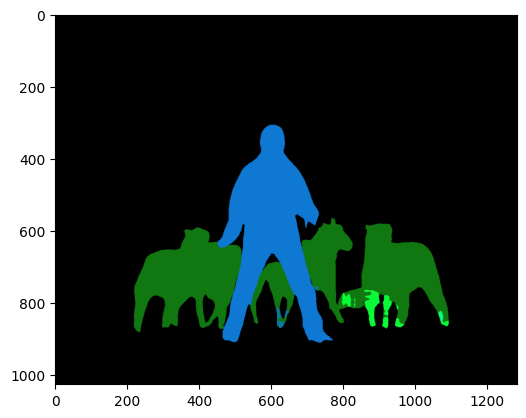

In [6]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()

### Model Description

FCN-ResNet is constructed by a Fully-Convolutional Network model, using a ResNet-50 or a ResNet-101 backbone.
The pre-trained models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

| Model structure |   Mean IOU  | Global Pixelwise Accuracy |
| --------------- | ----------- | --------------------------|
|  fcn_resnet50   |   60.5      |   91.4                    |
|  fcn_resnet101  |   63.7      |   91.9                    |

### Resources

 - [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1605.06211)

# Semantic Segmentation with ImageNet and ResNet-50

This notebook demonstrates how to load a custom-trained ImageNet model using a ResNet-50 backbone on a Jetson device and use it for semantic segmentation. The example provided focuses on segmenting images from a dataset.

## Sections

1. Prerequisites
2. Import Necessary Libraries
3. Set Up the Model
4. Load the Trained Model Weights
5. Preprocess the Input Image
6. Perform Inference
7. Visualize the Prediction
8. Conclusion

### Set Up the Model
We initialize a U-Net model with a ResNet-50 backbone. The model is set to use imagenet pretrained weights and expects 3-channel RGB input images. It outputs a single channel for binary segmentation.

In [ ]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(
    encoder_name="____",      # FIX ME # choose encoder, should be the same one as we use to train our model before
    encoder_weights="____",    # FIX ME # should be the same one as the one we use to train our model before
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

# Map the model to the CPU
model.load_state_dict(torch.load('___', map_location=torch.device('cpu'))) # FIX ME

/tmp/ipykernel_556531/3717739650.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/jupyter-thaqif/Qif/realsegmentation/floodsegmen

<All keys matched successfully>

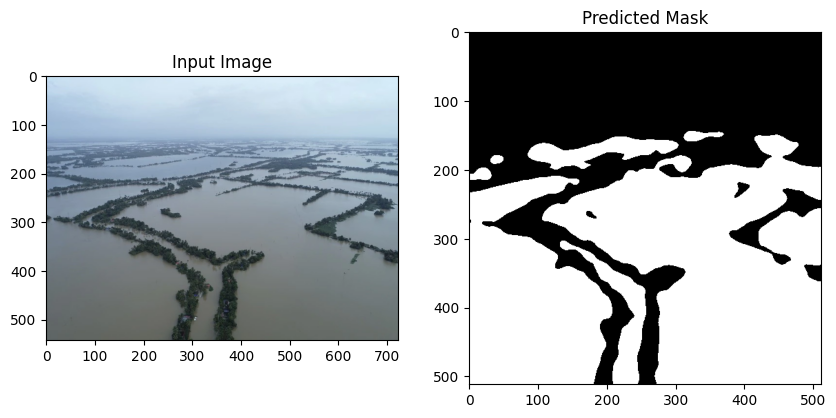

In [ ]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load the image
image_path = "test_images/1078.webp"
img = Image.open(image_path).convert('RGB')

# Resize the image using PIL (adjust size as per your model's requirements)
img_resized = img.resize((512, 512))

# Convert image to numpy array and normalize
img_resized = np.array(img_resized) / 255.0  # Scale pixel values to [0, 1]

# Convert to tensor and add batch dimension
img_resized = torch.tensor(img_resized, dtype=torch.float).permute(2, 0, 1).unsqueeze(0)

# Move image to device (CPU in this case)
img_resized = img_resized.to(torch.device('cpu'))

# Perform inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    pred = model(img_resized)
    pred = torch.sigmoid(pred).squeeze(0).squeeze(0).cpu().numpy()

# Binarize the prediction
pred = np.where(pred < 0.5, 0, 1).astype(np.uint8)
pred_img = Image.fromarray(pred * 255)  # Convert to 8-bit image

# Display the original image and the predicted segmentation mask
f, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(img)
axarr[0].set_title('Input Image')
axarr[1].imshow(pred_img, cmap='gray')
axarr[1].set_title('Predicted Mask')
plt.show()

## Conclusion
This notebook provides a template for loading and using a custom-trained U-Net model with a ResNet-50 backbone on Jetson devices for semantic segmentation. You can modify the code to suit your specific use case, such as adjusting the model architecture, dataset, or image preprocessing steps.